# 3. Solving Differential Equations with the Shooting Method
## B. The Radial Function

### Where we left off

We were able to solve for $S(\eta)$ of $\psi(\xi, \eta, \phi)=R(\xi)S(\eta)\Phi(\phi)$ for various values of $c^2$. In the process, we were also able to express $\Lambda$ as a fourth-degree polynomial of $c^2$. This was a particularly important achievement as this $\Lambda$ is also present in the differential equation for the radial equation $R(\eta)$. 

$$ \frac{d }{d \xi}\left [ \left ( \xi^2 - 1 \right ) \frac{d R}{d \xi} \right ] + \left [ 2D\xi + c^2 \xi^2 -\frac{\mu^2}{\xi^2 - 1} - \Lambda\left ( c^2 \right ) \right ]R = 0$$

Just like for $S(\eta)$, the function $R(\xi)$ can be expressed with another function $g(\xi)$ in the following way.

$$R(\xi)=\left ( \xi^2 - 1 \right ) ^{\mu/2} g(\xi)$$

Substituting yields

$$\left ( \xi^2 -1 \right ) g'' + 2\left ( \mu + 1 \right ) \xi \, g' + \left [2 D \xi +c^2 \xi^2 + \mu \left ( \mu + 1 \right ) - \Lambda\left ( c^2 \right )  \right ] g = 0$$

Note that as $c^2=\frac{1}{2}ED^2$, $c^2$ is dependent on $E$. Thus, with this differential equation, we intend to find values for $E$ which results in approprite $g(\xi)$ functions.

### Conditions on the function $g(\xi)$

Similar to $f(\eta)$, we let $g(1)=1$ and obtain $g'(1)$ from the limiting form of the equation above when $\xi \to 1+$.

$$g'(1)=-\frac{2D + c^2 + \mu\left ( \mu + 1 \right ) - \Lambda\left ( c^2 \right )}{2 \left ( \mu + 1 \right )}$$

The constraint for $f(\eta)$ was $f(0)=0$ or $f'(0)=0$ depending on the symmetry. The constraint for $g(\xi)$ is derived from the fact that the HMI is a bound state. Recall that for atomic orbitals, as $r \to \infty$, $\psi \to 0$. Thus, for the HMI, as $\xi \to \infty$, $\psi \to 0$. An actually implementable constraint is something like $g(\xi_{\text{cutoff}})=0$ where $\xi_{\text{cutoff}} \approx 10$. For $\xi > \xi_{\text{cutoff}}$, $g(\xi)=0$ thus $R(\xi)=0$. 

### The shooting method for $g(\xi)$

For this example, $\mu = 0$, $l = 0$, and $D = 2.0$.

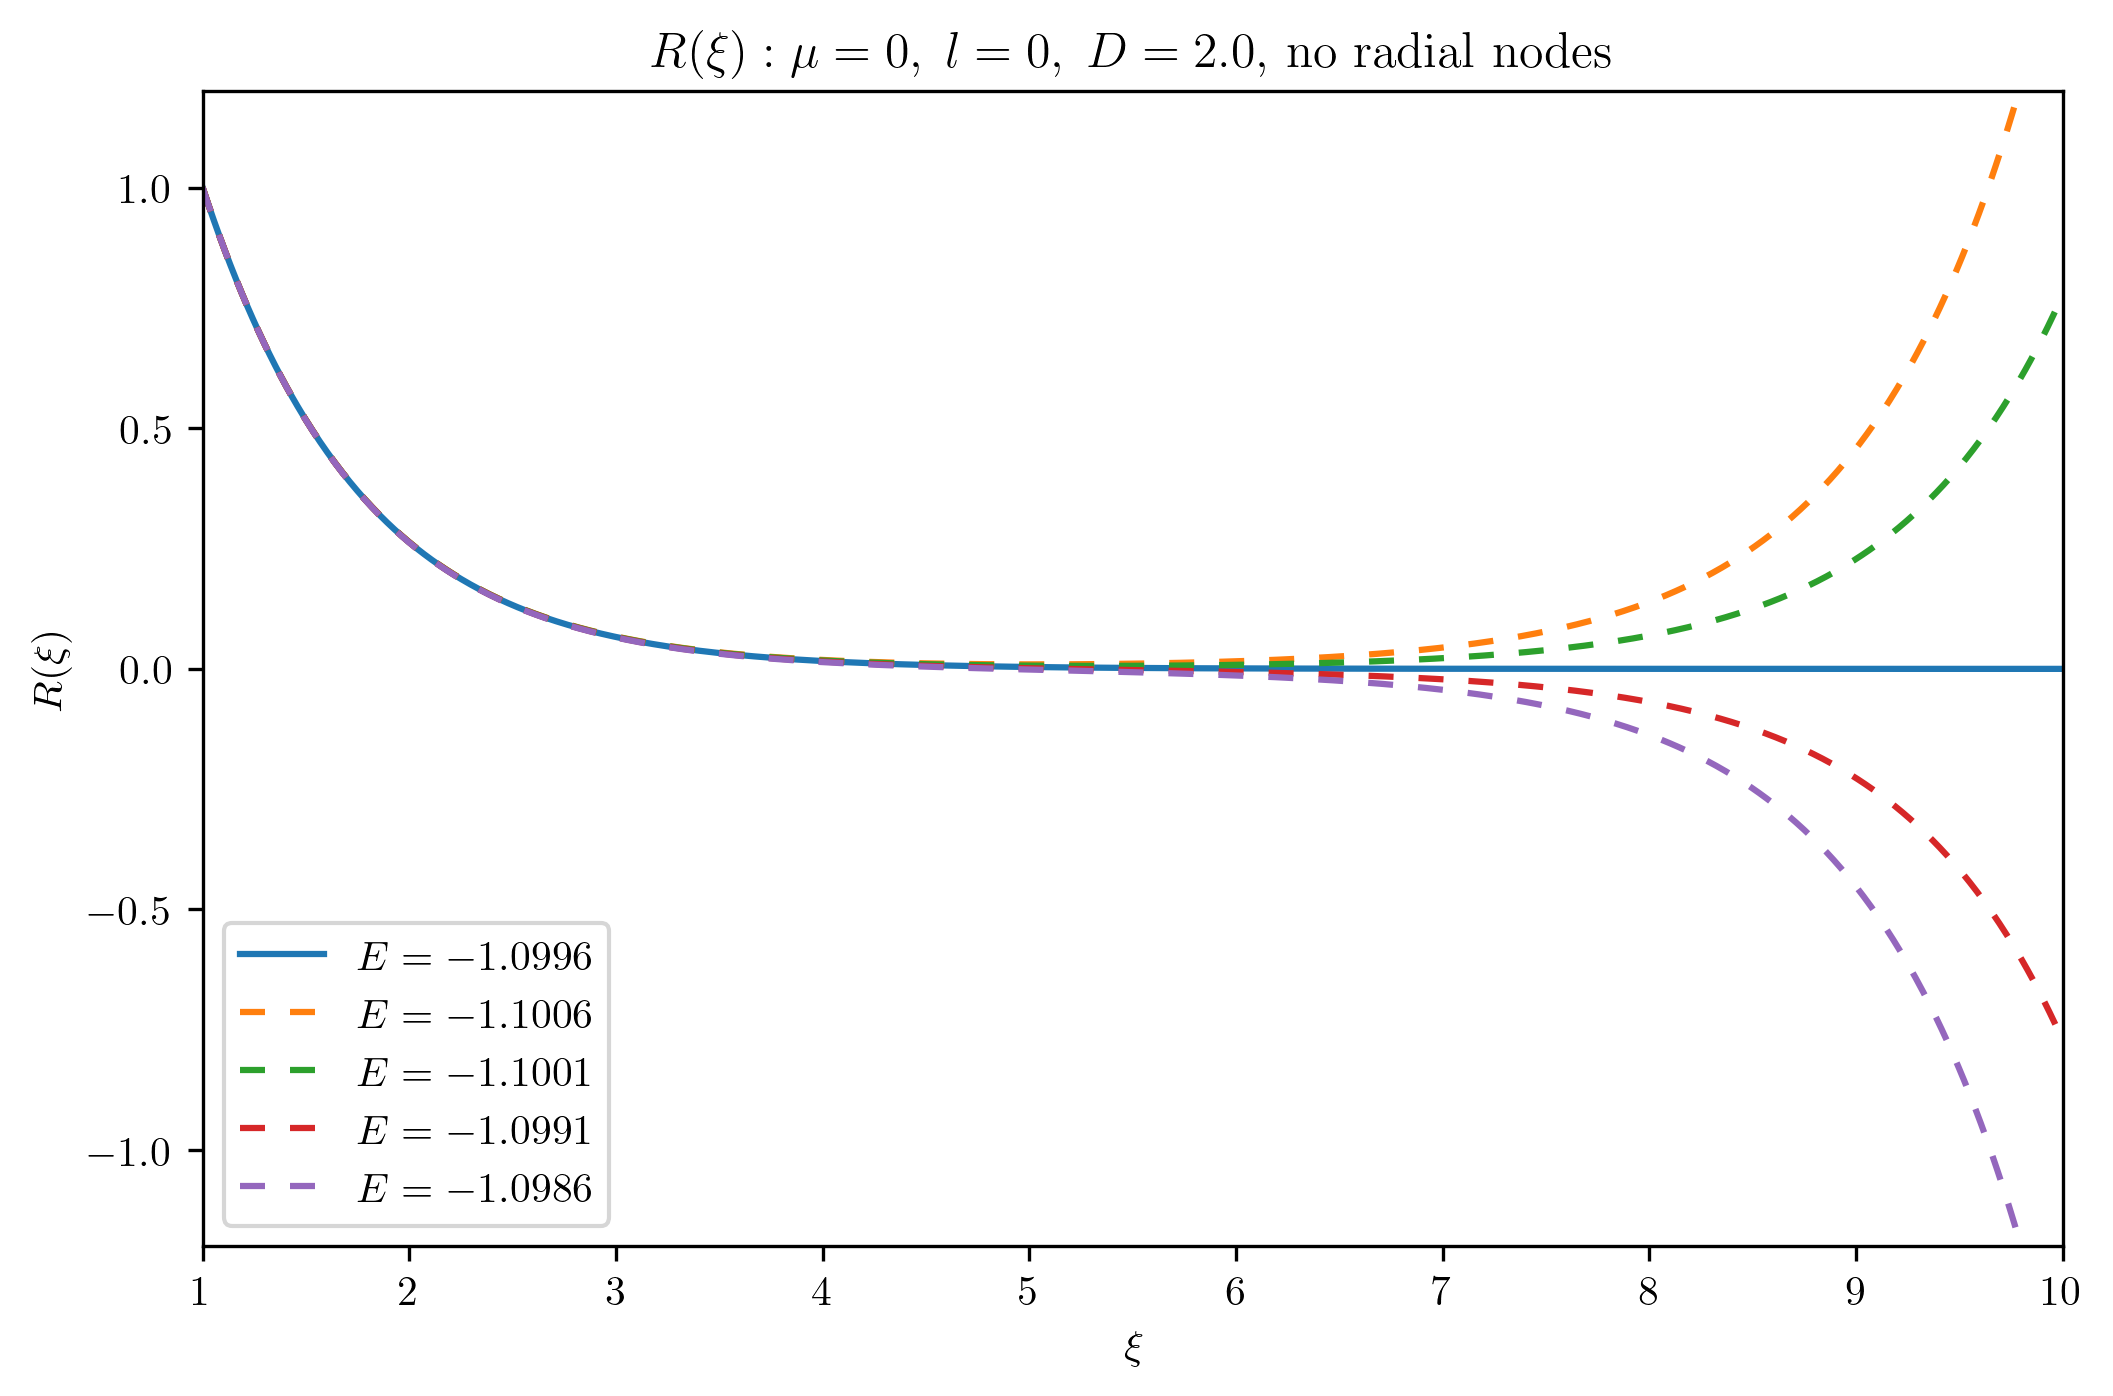

In [1]:
import os

import numpy as np
from numpy import polynomial as P 

from scipy.integrate import solve_ivp
from scipy.optimize import fsolve

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('default')

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "figure.dpi": 300,
    "savefig.dpi": 300,
    "figure.figsize": [8.0, 5.0]})

# Lambdas as polynomials calculated previously
# loaded in for use in this notebook
def get_lbda(l, mu):
    # only for values of mu and l
    # with already calculated Lambdas
    filename = f"lbda_{l}{mu}.txt"
    filedir = os.path.join(os.path.abspath(''), 
                           'data',
                           'lbda',
                           filename)
    lbda_coef = None
    with open(filedir, 'r') as file:
        lbda_coef = np.loadtxt(file)
    return P.Polynomial(lbda_coef)

# l, mu, as declared above
l = 0
mu = 0
D = 2.0
lbda = get_lbda(l, mu)

# for a given E_val, solve R(xi)
# also calculates g(cutoff) for optimization step
# shown later in the notebook
def calculate_R(l, mu, E_val, lbda, cutoff=10, g10_instead=False):
    """Returns a series of values of R or the value of g(10)"""
    
    c2 = (1/2) * E_val * (D**2)

    # initial value of g and g' (at xi = 1)
    q1 = np.array([1,-(2*D + c2 + mu*(mu+1) - lbda(c2))/(2*(mu+1))])
    
    # relates g' and g'' with g and g'
    G = lambda xi, q: np.array([[0, 1],
    [-(2*D*xi + c2*(xi**2) + mu*(mu+1) - lbda(c2))/(xi**2 - 1),
    -(2*(mu+1)*xi)/(xi**2 - 1)]]) @ q
    
    # solve for g(xi) for 1 < xi <= 10
    # exclude xi = 1 to avoid a ZeroDivisionError
    xi_span = np.linspace(1, cutoff, cutoff*100)
    eps = 1.0e-10
    xi_span[0] = 1.0+eps
    
    
    if g10_instead:
        # for optimization only, return value of g(10)
        sol = solve_ivp(G, [1 + eps, cutoff], q1, t_eval=[xi_span[-1]])
        return sol.y[0][-1]
    else:
        sol = solve_ivp(G, [1 + eps, cutoff], q1, t_eval=xi_span)
        # calculate R from g
        R_vals = ((xi_span ** 2 - 1)**(mu/2)) * sol.y[0]

        # add back R(xi) = 0 or 1 depending on mu
        R_vals[0] = 1.0 if mu == 0 else 0.0

        return xi_span, R_vals

    
# using the shooting method
cutoff = 10
E_val_guess = -1.1

@np.vectorize
def objective(E_val):
    return calculate_R(l, mu, E_val, lbda, 
                       cutoff=cutoff, g10_instead=True)

E_val_final, = fsolve(objective, E_val_guess)


# evaluate R_vals of E_val_final -0.2, 0, +0.2
E_vals = np.array([0, -0.001, -0.0005, 0.0005, 0.001]) + E_val_final

fig, ax = plt.subplots()

for ind, E_val in enumerate(E_vals):
    xi_span, R_vals = calculate_R(l, mu, E_val, lbda)
    E_val_label = f'$E = {E_val:.4f}$'
    
    # solid line for correct E_val, dashed for others
    if ind == 0:
        ls = '-'
    else:
        ls=(0, (4, 4))
        
    ax.plot(xi_span, R_vals, label=E_val_label, ls=ls)

    
ax.set_title((fr'$R(\xi) : \mu = {mu}, \; '
             fr'l = {l}, \; D = {D}$, no radial nodes'))
ax.legend()
ax.set_ylim(-1.2, 1.2)
ax.set_xlim(1, 10)
ax.set_xlabel(r'$\xi$')
ax.set_ylabel(r'$R(\xi)$');

Note that with different initial guesses of $E$, a different $R(\xi)$ of the same $l, \mu$, and $D$ can be also be calculated. Note that for $R(\xi)$ of higher $E$, we need to use a greater $\xi_{\text{cutoff}}$ to attain accurate results.

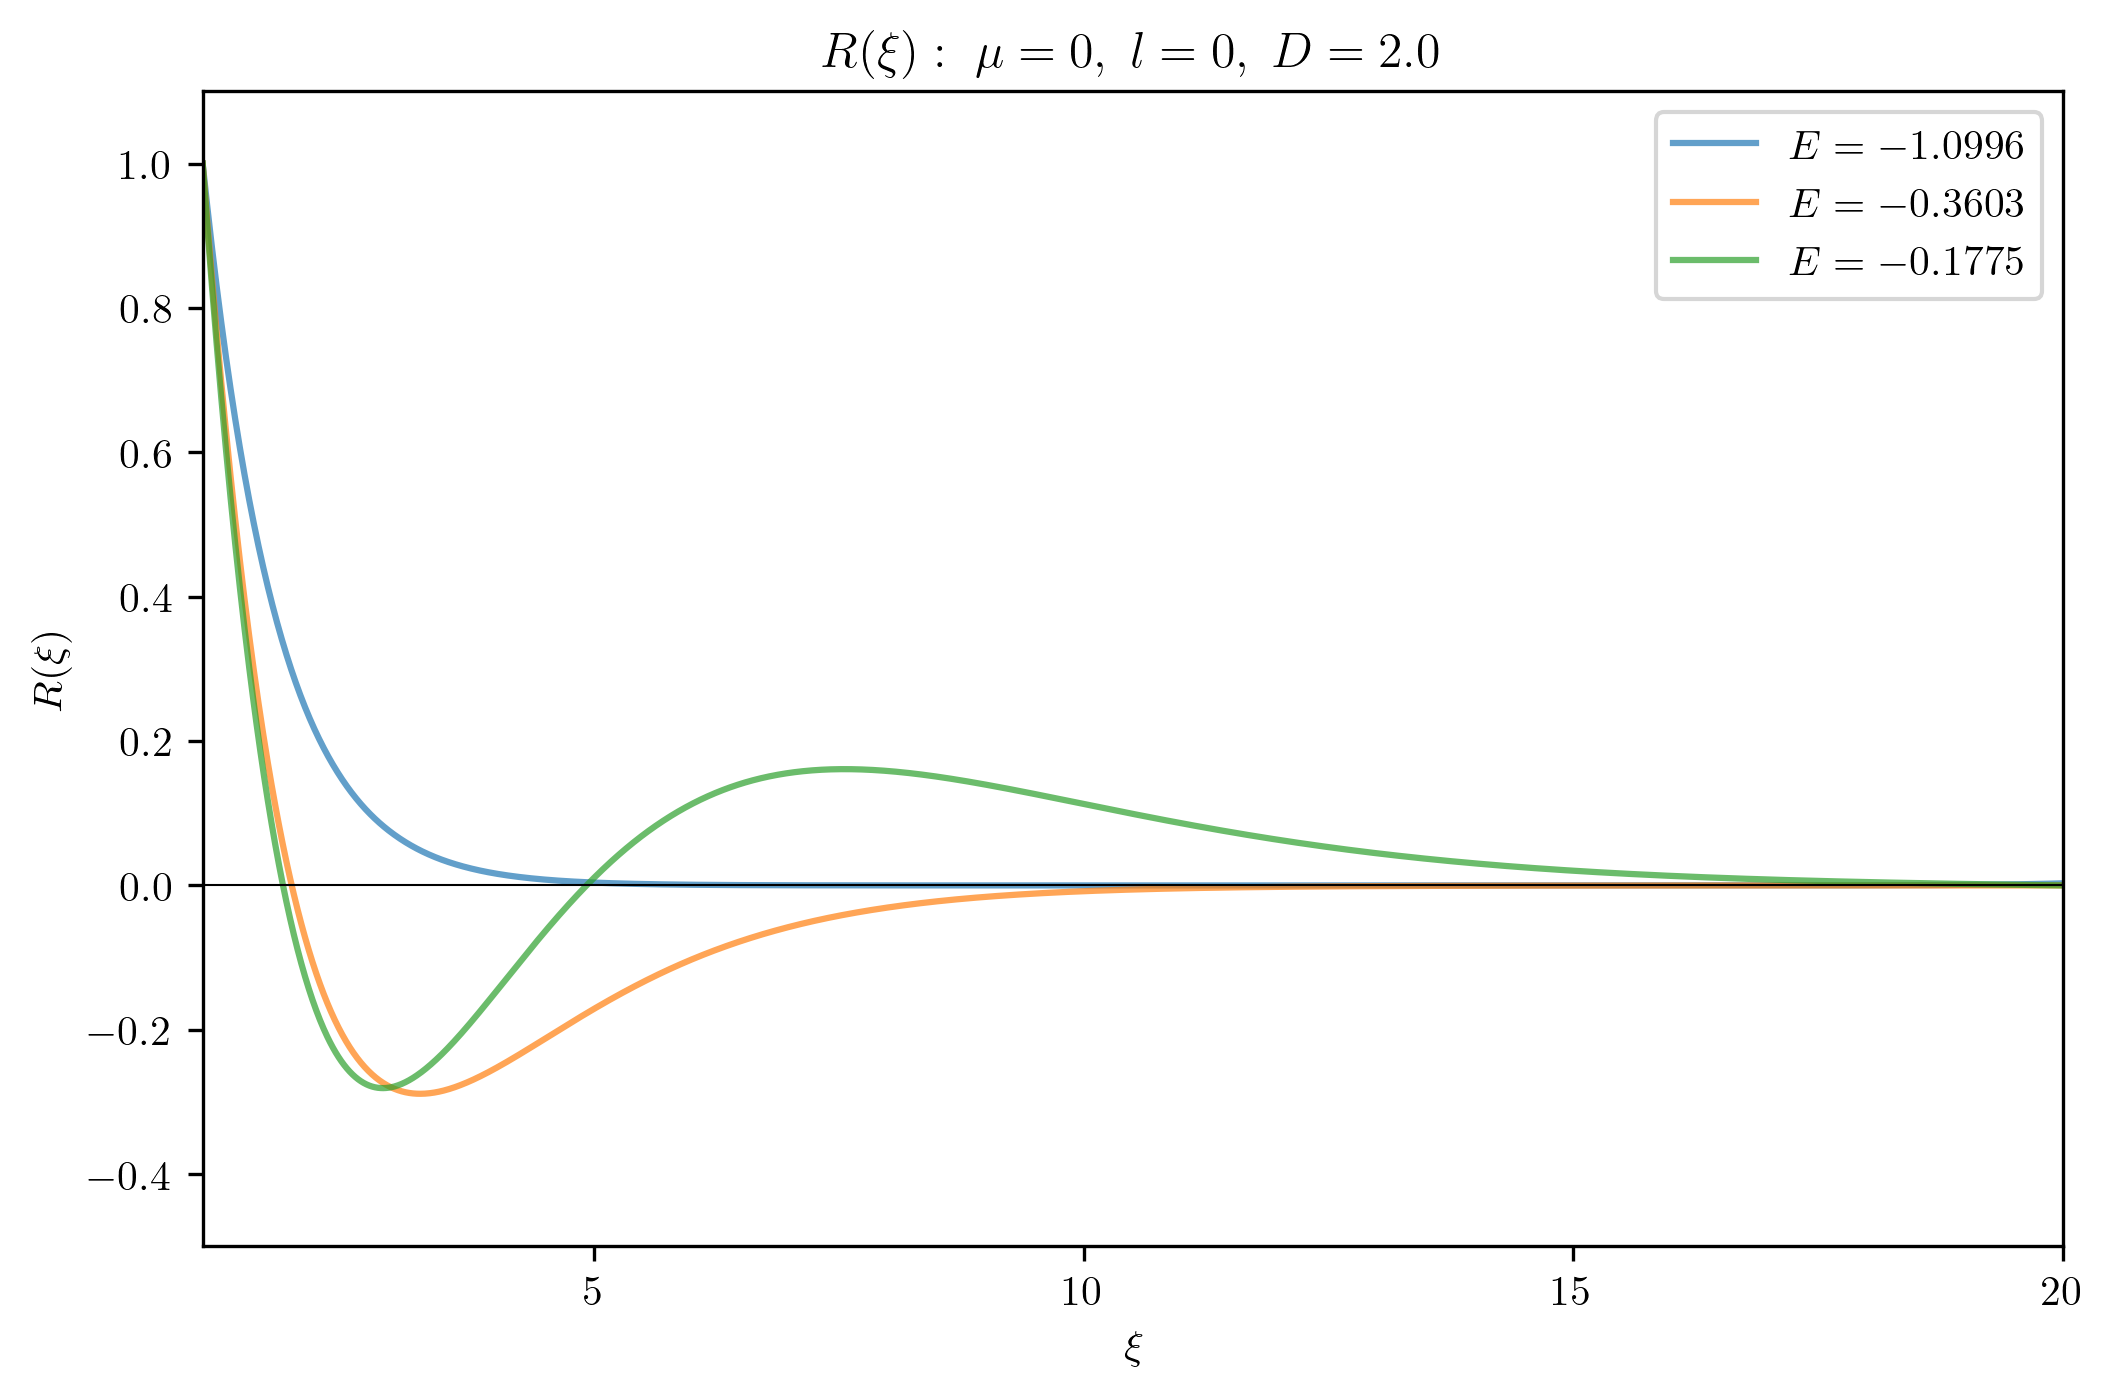

In [2]:
# greater cutoff value for higher energy states
cutoff = 20

fig, ax = plt.subplots()

for ind, E_val_guess in enumerate([-1.10, -0.36, -0.17]):
    E_val_final, = fsolve(objective, E_val_guess)

    xi_span, R_vals = calculate_R(l, mu, E_val_final, 
                                  lbda, cutoff=cutoff)

    E_val_label = f'$E = {E_val_final:.4f}$'
    ax.plot(xi_span, R_vals, label=E_val_label)
    ax.set_title(fr'$R(\xi) : \; \mu = {mu}, \; l = {l}, \; D = {D}$')
    ax.legend()
    ax.set_ylim(-0.5, 1.1)
    ax.set_xticks([5.0, 10.0, 15.0, 20.0])
    ax.set_xlim(1, 20)

ax.axhline(y=0, color='k', linewidth = 0.5)
ax.set_xlabel(r'$\xi$')
ax.set_ylabel(r'$R(\xi)$');

As $E$ increases, the number of radial nodes increases, just like atomic orbitals. We designate $n$ to be the number of radial nodes + 1, in order to have $(n, l, \mu)$ of MOs match that of the AOs.

Note that this $n$ is not the number used in the MO notation such as $2 \sigma_g$. The number in this notation (called exact MO notation or simply numbering by symmetry) means that the MO has the first lowest energy among the MOs with the same symmetry. For example, $2 \sigma_g$ has the second lowest energy among $\sigma_g$ molecular orbitals.

Below is a table that compares the exact MO notation, LCAO-MO notation(also known as the separated-atoms description), the united-atom description, and the $(n, l, \mu)$ used extensively from this point on.

|<div style="width:100px">Exact MO</div>|<div style="width:100px">LCAO-MO</div>|<div style="width:100px">United atom equivalent</div>|<div style="width:100px">$(n, l, \mu)$ </div>|
|:------------------:|:-----------------------------------------:|:-------------------:|:-------------:|
| $1 \sigma_{g}$     | $\sigma_{g1s}$                            | $1s$                |  $(1, 0, 0)$  |
| $1 \sigma_{u}^{*}$ | $\sigma_{u1s}^{*}$                        | $2p_{z}$            |  $(2, 1, 0)$  |
| $1 \pi_{u}$        | $\pi_{u2p_{x}} \; \pi_{u2p_{y}}$          | $2p_{x} \; 2p_{y}$  |  $(2, 1, 1)$  |
| $2 \sigma_{g}$     | $\sigma_{g2s}$                            | $2s$                |  $(2, 0, 0)$  |
| $2 \sigma_{u}^{*}$ | $\sigma_{u2s}^{*}$                        | $3p_{z}$            |  $(3, 1, 0)$  |
| $3 \sigma_{g}$     | $\sigma_{g2p_{x}}$                        | $3d_{z^2}$          |  $(3, 2, 0)$  |
| $1 \pi_{g}^{*}$    | $\pi_{g2p_{x}}^{*} \; \pi_{g2p_{y}}^{*}$  | $3d_{xz} \; 3d_{yz}$|  $(3, 2, 1)$  |
| $3 \sigma_{u}^{*}$ | $\sigma_{u2p_{z}}^{*}$                    | $4f_{z^3}$          |  $(4, 3, 0)$  |

## C. Electronic Energy and Total Energy of Molecular Orbitals
### Before calculating the actual wavefunctions

With a given value of $D, \, n, \, l,$ and $\mu$, we were able to obtain the necessary $\Phi(\phi), \, S(\eta),$ and $R(\xi)$ to construct a complete not-yet-normalized $\psi(\xi, \eta, \phi)$. Before we do so, let us investigate how the changes in $D$ affects the $E$ from $R(\xi)$ (which is the $E$ of $\psi(\xi, \eta, \phi)$), similar to how we dealt with $c^2$ and $\Lambda$ in the previous section. Unlike the previous section, the relationship between $D$ and $E$ are of special concern, as it allows us to determine the equilibrium internuclear distance.

### Electronic Energy

Below is the graph of electronic energy with varying internuclear distances $D$. The solid lines are data calculated from the script below. The dotted lines are formed through extrapolation, as calculations with small values of $D$ are often inaccurate.

Note: for calculations with small values of D, increase the cutoff value for better results.

In [3]:
# MOs to be calculated (in the order of E for D = 2.0)
mos = [
    '1 sigma g',
    '1 sigma u *',
    '1 pi u',
    '2 sigma g',
    '2 sigma u *',
    '3 sigma g',
    '1 pi g *',
    '3 sigma u *',
]

# quantum numbers (l, mu) and energy estimate
mo_nums = {
    '1 sigma g': (0, 0, -1.35),
    '1 sigma u *': (1, 0, -0.7),
    '1 pi u': (1, 1, -0.45),
    '2 sigma g': (0, 0, -0.4),
    '2 sigma u *': (1, 0, -0.4),
    '3 sigma g': (2, 0, -0.4),
    '1 pi g *': (2, 1, -0.4),
    '3 sigma u *':(3, 0, -0.2),
}

# energy of MOs as they approach the united atom limit
# note: the energy levels of a He+ ion is -2/(n**2)
mo_united_atom_E = {
    '1 sigma g': -2/1,
    '1 sigma u *': -2/4,
    '1 pi u': -2/4,
    '2 sigma g': -2/4,
    '2 sigma u *': -2/9,
    '3 sigma g': -2/9,
    '1 pi g *': -2/9,
    '3 sigma u *': -2/16,
}

# MO notation in LaTeX
mo_latex = {
    '1 sigma g': r"$1 \sigma_{g}$",
    '1 sigma u *': r"$1 \sigma_{u}^{\ast}$",
    '1 pi u': r"$1 \pi_{u}$",
    '2 sigma g' : r"$2 \sigma_{g}$",
    '3 sigma g' : r"$3 \sigma_{g}$",
    '2 sigma u *' : r"$2 \sigma_{u}^{*}$",
    '1 pi g *' : r"$1 \pi_{g}^{*}$",
    '3 sigma u *' : r"$3 \sigma_{u}^{*}$",
}

# this determines where interpolation ends and extrapolation starts
mo_border = {
    '1 sigma g': 0.4,
    '1 sigma u *': 1.2,
    '1 pi u': 1.2,
    '2 sigma g' : 1.2,
    '3 sigma g' : 1.5,
    '2 sigma u *' : 1.5,
    '1 pi g *' : 1.5,
    '3 sigma u *' : 1.7,
}


# we actually calculate only about 20 data points
# as the cost of calculation is pretty high.
# interp1d is used to reconstruct the region inbetween data points
from scipy.interpolate import interp1d

# store intrapolated and extrapolated data points
# to be plotted
mo_interpolated = dict()
mo_extrapolated = dict()

# calculation done here
for mo in mos:
    l, mu, E_guess = mo_nums[mo]
    lbda = get_lbda(l, mu)
    
    # greater values of l require greater cutoff values
    if l == 0:
        cutoff = 15
    elif l == 1 or l == 2:
        cutoff = 20
    elif l == 3:
        cutoff = 40
    
    # much more detailed graph for the bonding MO
    if mo == '1 sigma g':
        D_vals = np.concatenate([np.linspace(mo_border[mo], 3.0, 30), 
                                 np.linspace(3.1, 10.0, 20)], axis=0)
    else:
        D_vals = np.linspace(mo_border[mo], 10.0, 30)
    
    E_vals = []
    for D in D_vals:
        E_val, = fsolve(objective, E_guess)
        E_vals.append(E_val)

        
    D_span_interp = np.linspace(mo_border[mo], 10.0, 200)
    E_vals_interp = interp1d(D_vals, E_vals, 
                             kind='cubic')(D_span_interp)
    
    # saving to a variable for total energy graph
    mo_interpolated[mo] = {
        'D': D_span_interp,
        'E': E_vals_interp,
    }
    
    # for 1 sigma g - extrapolation unnecessary
    if mo == '1 sigma g':
        continue
    
    # extrapolate to united atom limit using the first 5 values,
    # setting E as its theoretical, united atom limit value at D = 0.0
    D_for_extrap = np.concatenate([np.array([0]), D_vals[:5]])
    E_for_extrap = np.concatenate(
        [np.array([mo_united_atom_E[mo]]), E_vals[:5]])
    
    # up to 1e-3 to avoid a ZeroDivisionError for the total energy graph
    D_span_extrap = np.linspace(mo_border[mo], 1e-3, 20)
    E_vals_extrap = interp1d(D_for_extrap, E_for_extrap, 
                             kind='cubic')(D_span_extrap)
    
    # saving to a variable for total energy graph
    mo_extrapolated[mo] = {
        'D': D_span_extrap,
        'E': E_vals_extrap,
    }
    
    
# uncomment the lines below to see the electronic energy at D = 2.0
# with full accuracy, used in the next notebook 4_graph.ipynb
"""
D = 2.0

for mo in mos:
    l, mu, E_guess = mo_nums[mo]
    lbda = get_lbda(l, mu)
    
    E_val, = fsolve(objective, E_guess)
    
    print(f'{mo}: {E_val:.100g}')
""";

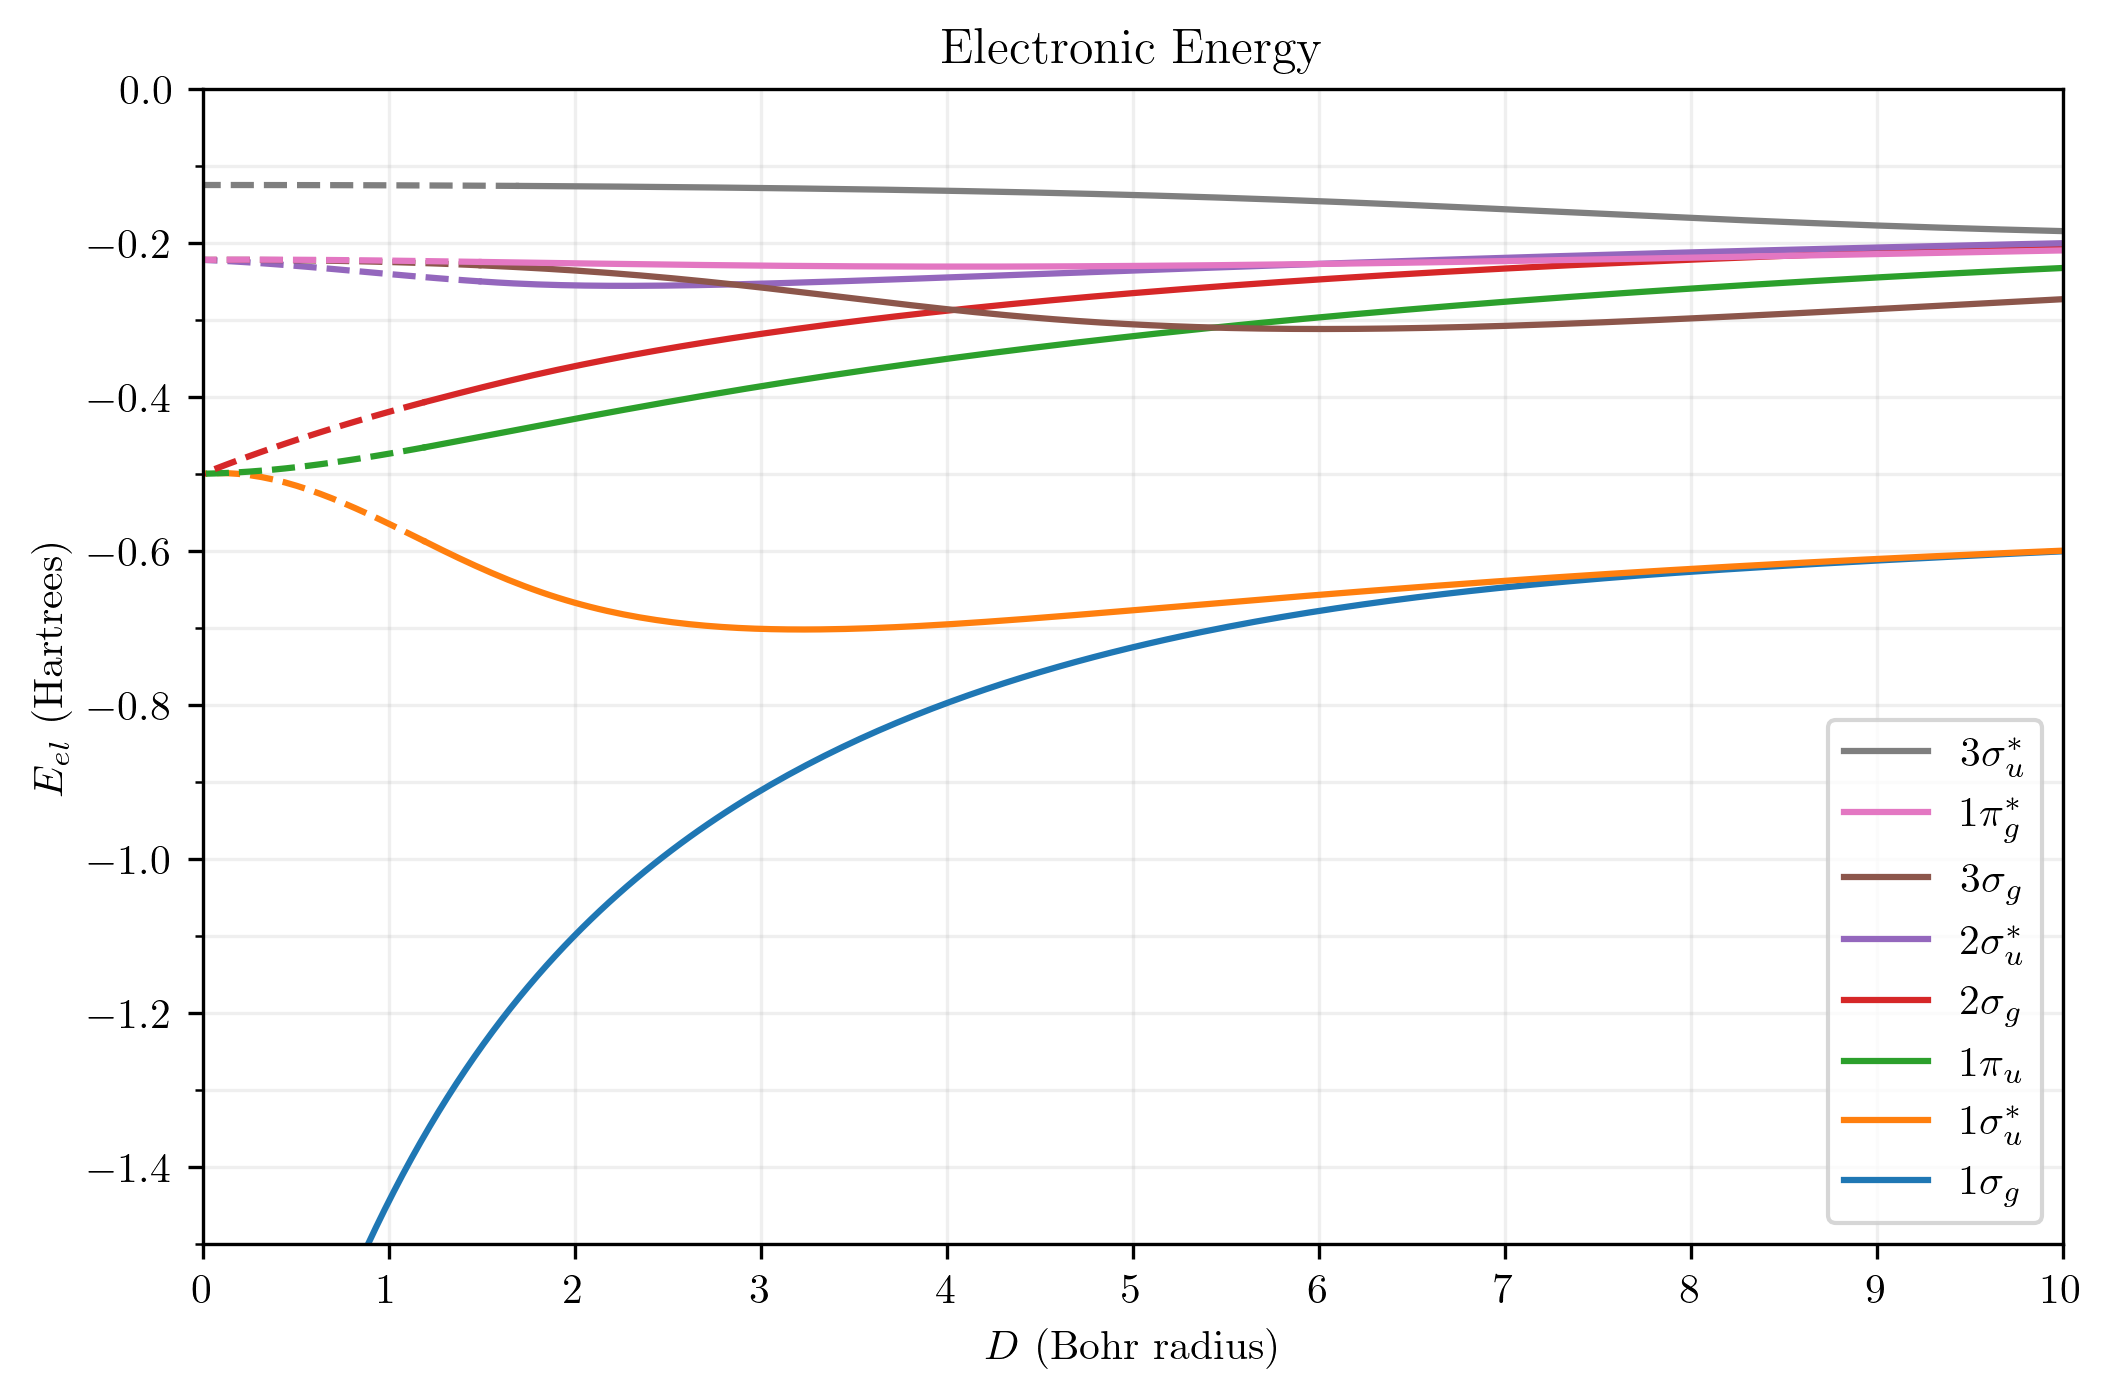

In [4]:
# graph plotting

fig, ax = plt.subplots()

for ind, mo in enumerate(mos):
    
    D_interp = mo_interpolated[mo]['D']
    E_interp = mo_interpolated[mo]['E']
    
    p = ax.plot(D_interp, E_interp, label=mo_latex[mo])
    
    # for 1 sigma g - extrapolation unnecessary
    if mo == '1 sigma g':
        continue
    
    D_extrap = mo_extrapolated[mo]['D']
    E_extrap = mo_extrapolated[mo]['E']
    
    ax.plot(D_extrap, E_extrap, 
            color=p[0].get_color(), ls='--', dash_capstyle='butt')

    
# legend order reversed (from lowest E to highest)
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), loc=4)

ax.grid(which='both', alpha=0.2)
ax.set_xlim([0, 10])
ax.set_ylim([-1.5, 0])
ax.set_xlabel('$D$ (Bohr radius)')
ax.set_ylabel('$E_{el}$ (Hartrees)')
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))
ax.set_title('Electronic Energy');

To analyze this graph, we focus on two things: when $D \to 0$ and $D \to \infty$.

When the united atom limit is taken ($D \to 0$), the energy of MO approaches that of the corresponding AO ($E_{el} = -Z^2 /\left ( 2n^2 \right )$). In fact, this conclusion is obtained the other way around. With the knowledge that the $E_{el}$ approaches that of the AO, the extrapolation purposefully connects the computational data (solid line) with the theoretical limit at $D = 0$.

When the separated atom limit is taken ($D \to \infty$), the energy of MO approaches that of the corresponding AO (indicated by the LCAO-MO notation) and a bare proton (which is $E = 0$). Although not explicitly shown in the graph above, for $1 \sigma_g$ and $1 \sigma_u^*$, $E_{el} \to -1/(2 \times 1^2)$. Similarly, for all other MOs, $E_{el} \to -1/(2 \times 2^2)$.

### Total Energy
For most situations, we have omitted the internuclear repulsion term. Now is the time to add the repulsion term back in, in order to obtain the total energy of the HMI.
$$E_{tot} = E_{el} + \frac{1}{D}$$

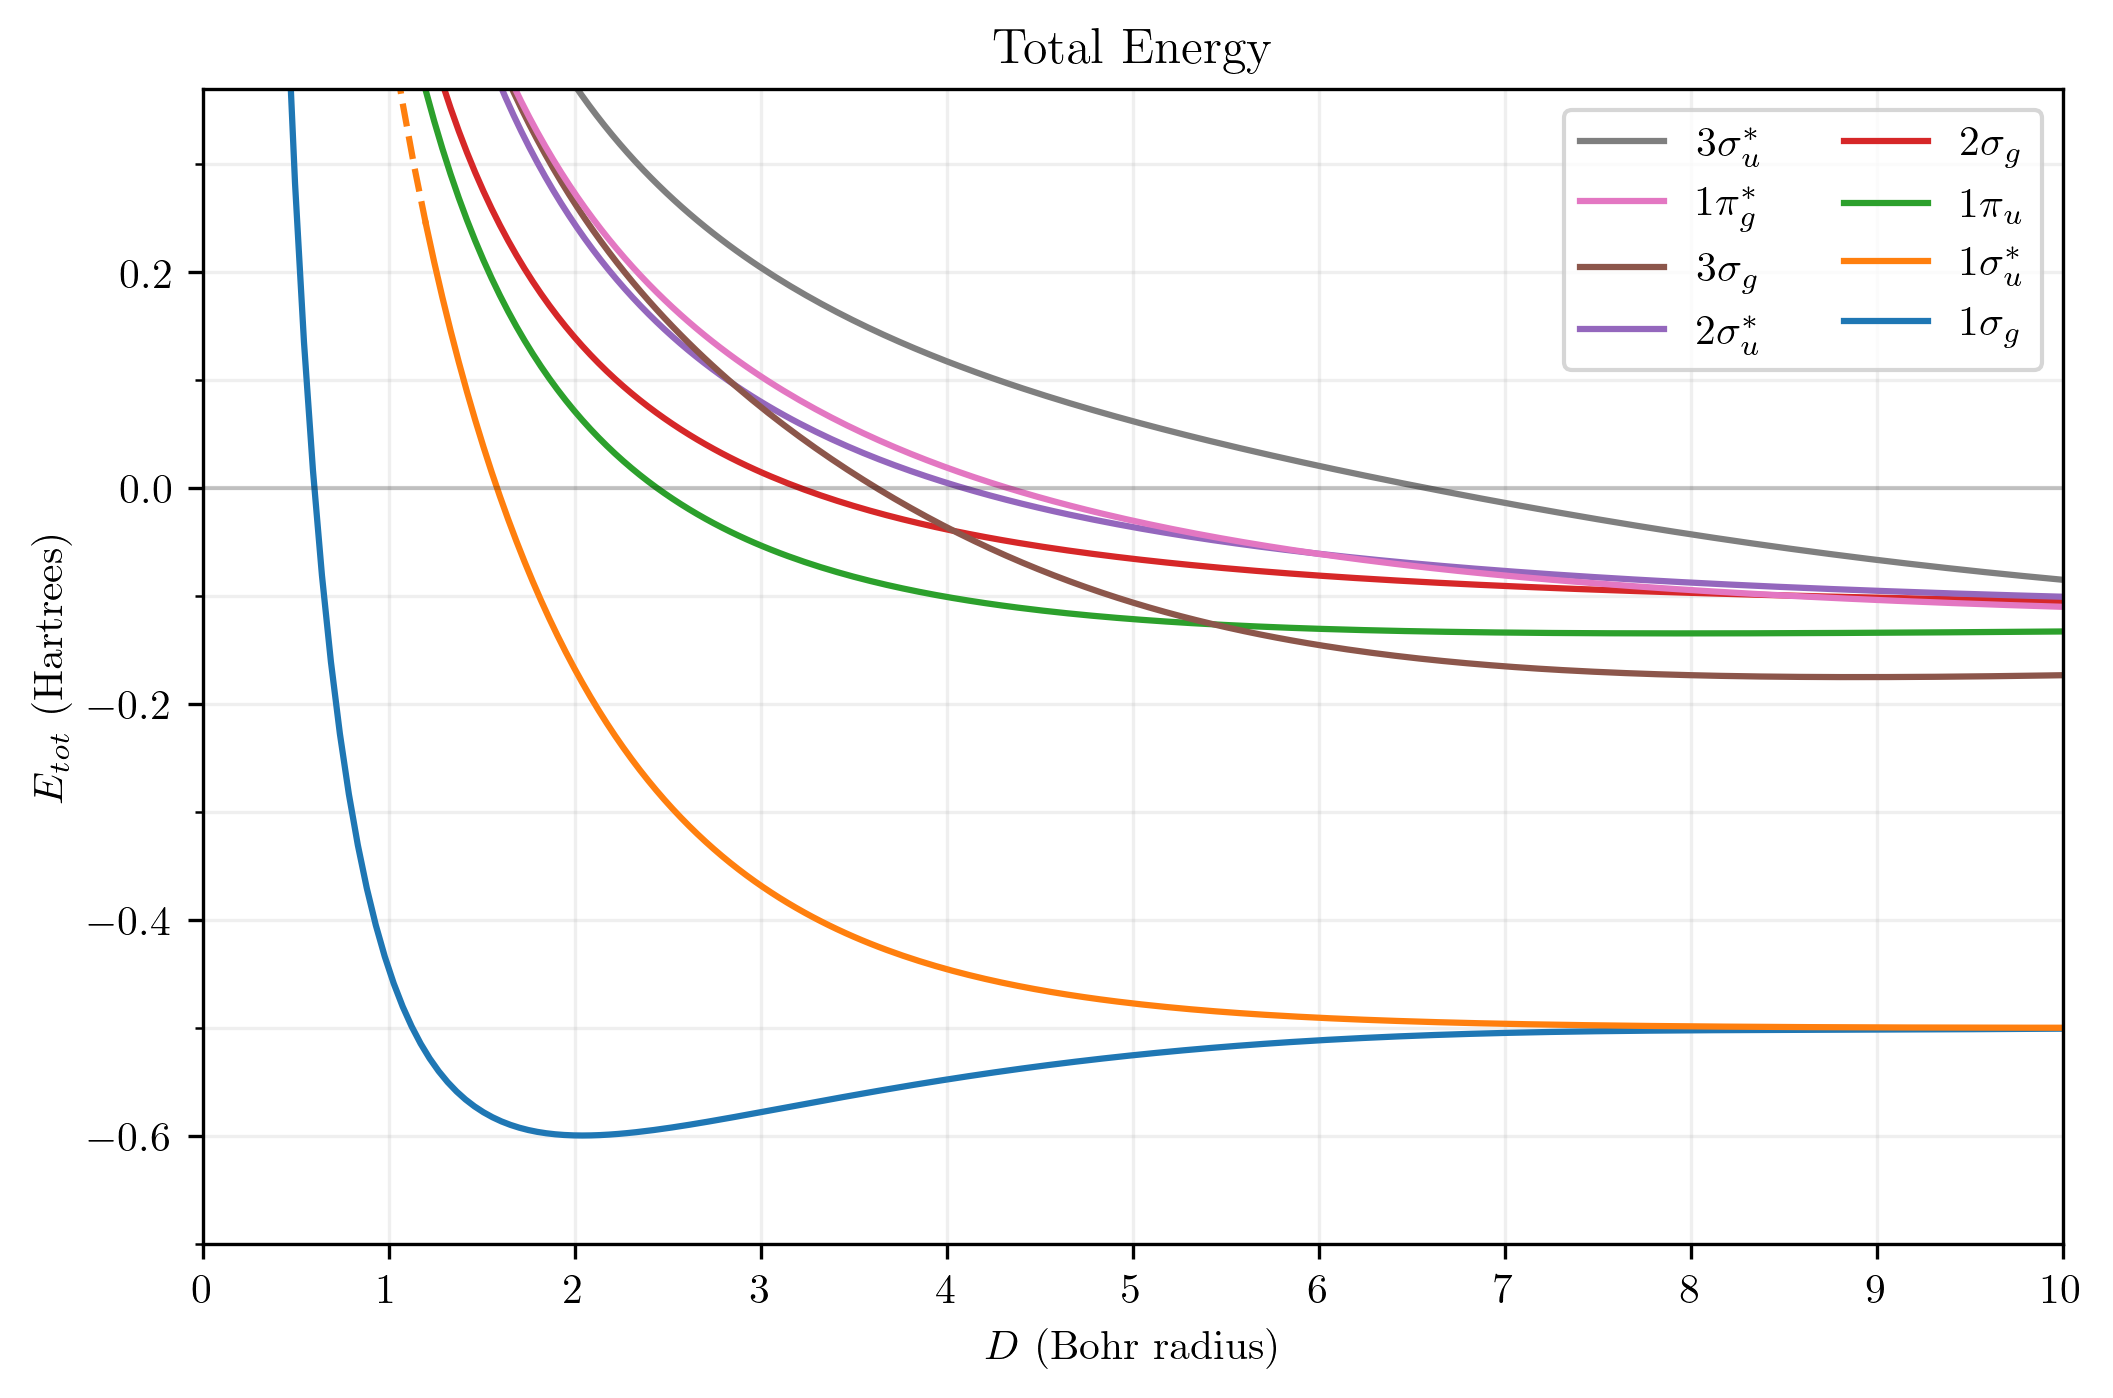

In [5]:
fig, ax = plt.subplots()

for ind, mo in enumerate(mos):
    
    D_interp = mo_interpolated[mo]['D']
    E_interp = mo_interpolated[mo]['E'] + 1/D_interp
    
    p = ax.plot(D_interp, E_interp, label=mo_latex[mo])
    
    if mo == '1 sigma u *':
        D_extrap = mo_extrapolated[mo]['D']
        E_extrap = mo_extrapolated[mo]['E']+ 1/D_extrap

        ax.plot(D_extrap, E_extrap, 
                color=p[0].get_color(), ls='--', dash_capstyle='butt')


ax.axhline(y=0, color='k', alpha=0.2, linewidth=1) 

# reversed legend order
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), loc=1, ncol=2)

ax.grid(which='both', alpha=0.2)
ax.set_xlim([0, 10])
ax.set_ylim([-0.7, 0.37])
ax.set_xlabel('$D$ (Bohr radius)')
ax.set_ylabel('$E_{tot}$ (Hartrees)')
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))
ax.set_title('Total Energy');

From this graph, the only MO with an energy minimum deep enough for bonding is $1 \sigma_{g}$. All other MOs either have no energy minimum, or their energy minimum is too shallow - leading to formation of very weak bonds of little importance.

### Bonding and Antibonding / HOMO and LUMO
Because the HMI has only one electron, the ground state of this system is $1 \sigma_{g}$ and the first excited state is $1 \sigma_{u}^{*}$. Although higher excited states are technically possible, they are very rare and are often ignored.

With that being said, let us closely investigate the HOMO ($1 \sigma_{g}$) and LUMO ($1 \sigma_{u}^{*}$), which are also bonding and antibonding MOs. The code below draws the total energy graph with greater accuracy than before, while also calculating the energy minimum with high accuracy.


In [6]:
# for use in finding the minimum and later examples
mos = ['1 sigma g', '1 sigma u *']

# uncomment the lines below
# to find the minimum of 1 sigma g using fsolve
"""
l, mu = 0, 0
lbda = get_lbda(l, mu)

from scipy.optimize import minimize_scalar

@np.vectorize
def E_given_D(D_val):
    global D
    D = D_val
    return fsolve(objective, -1.3)[0] + 1/D_val


res = minimize_scalar(E_given_D, bounds=(1.95, 2.10), method='bounded')
min_E_D = res.x
min_E = res.fun

print(f'{min_E_D:.100g}, {min_E:.100g}')
"""

# pre-calculated values
min_E_D = 2.041764494145241304323690201272256672382354736328125
min_E = -0.5997125234416447181473586169886402785778045654296875

2.041764494145241304323690201272256672382354736328125, -0.5997125234416447181473586169886402785778045654296875


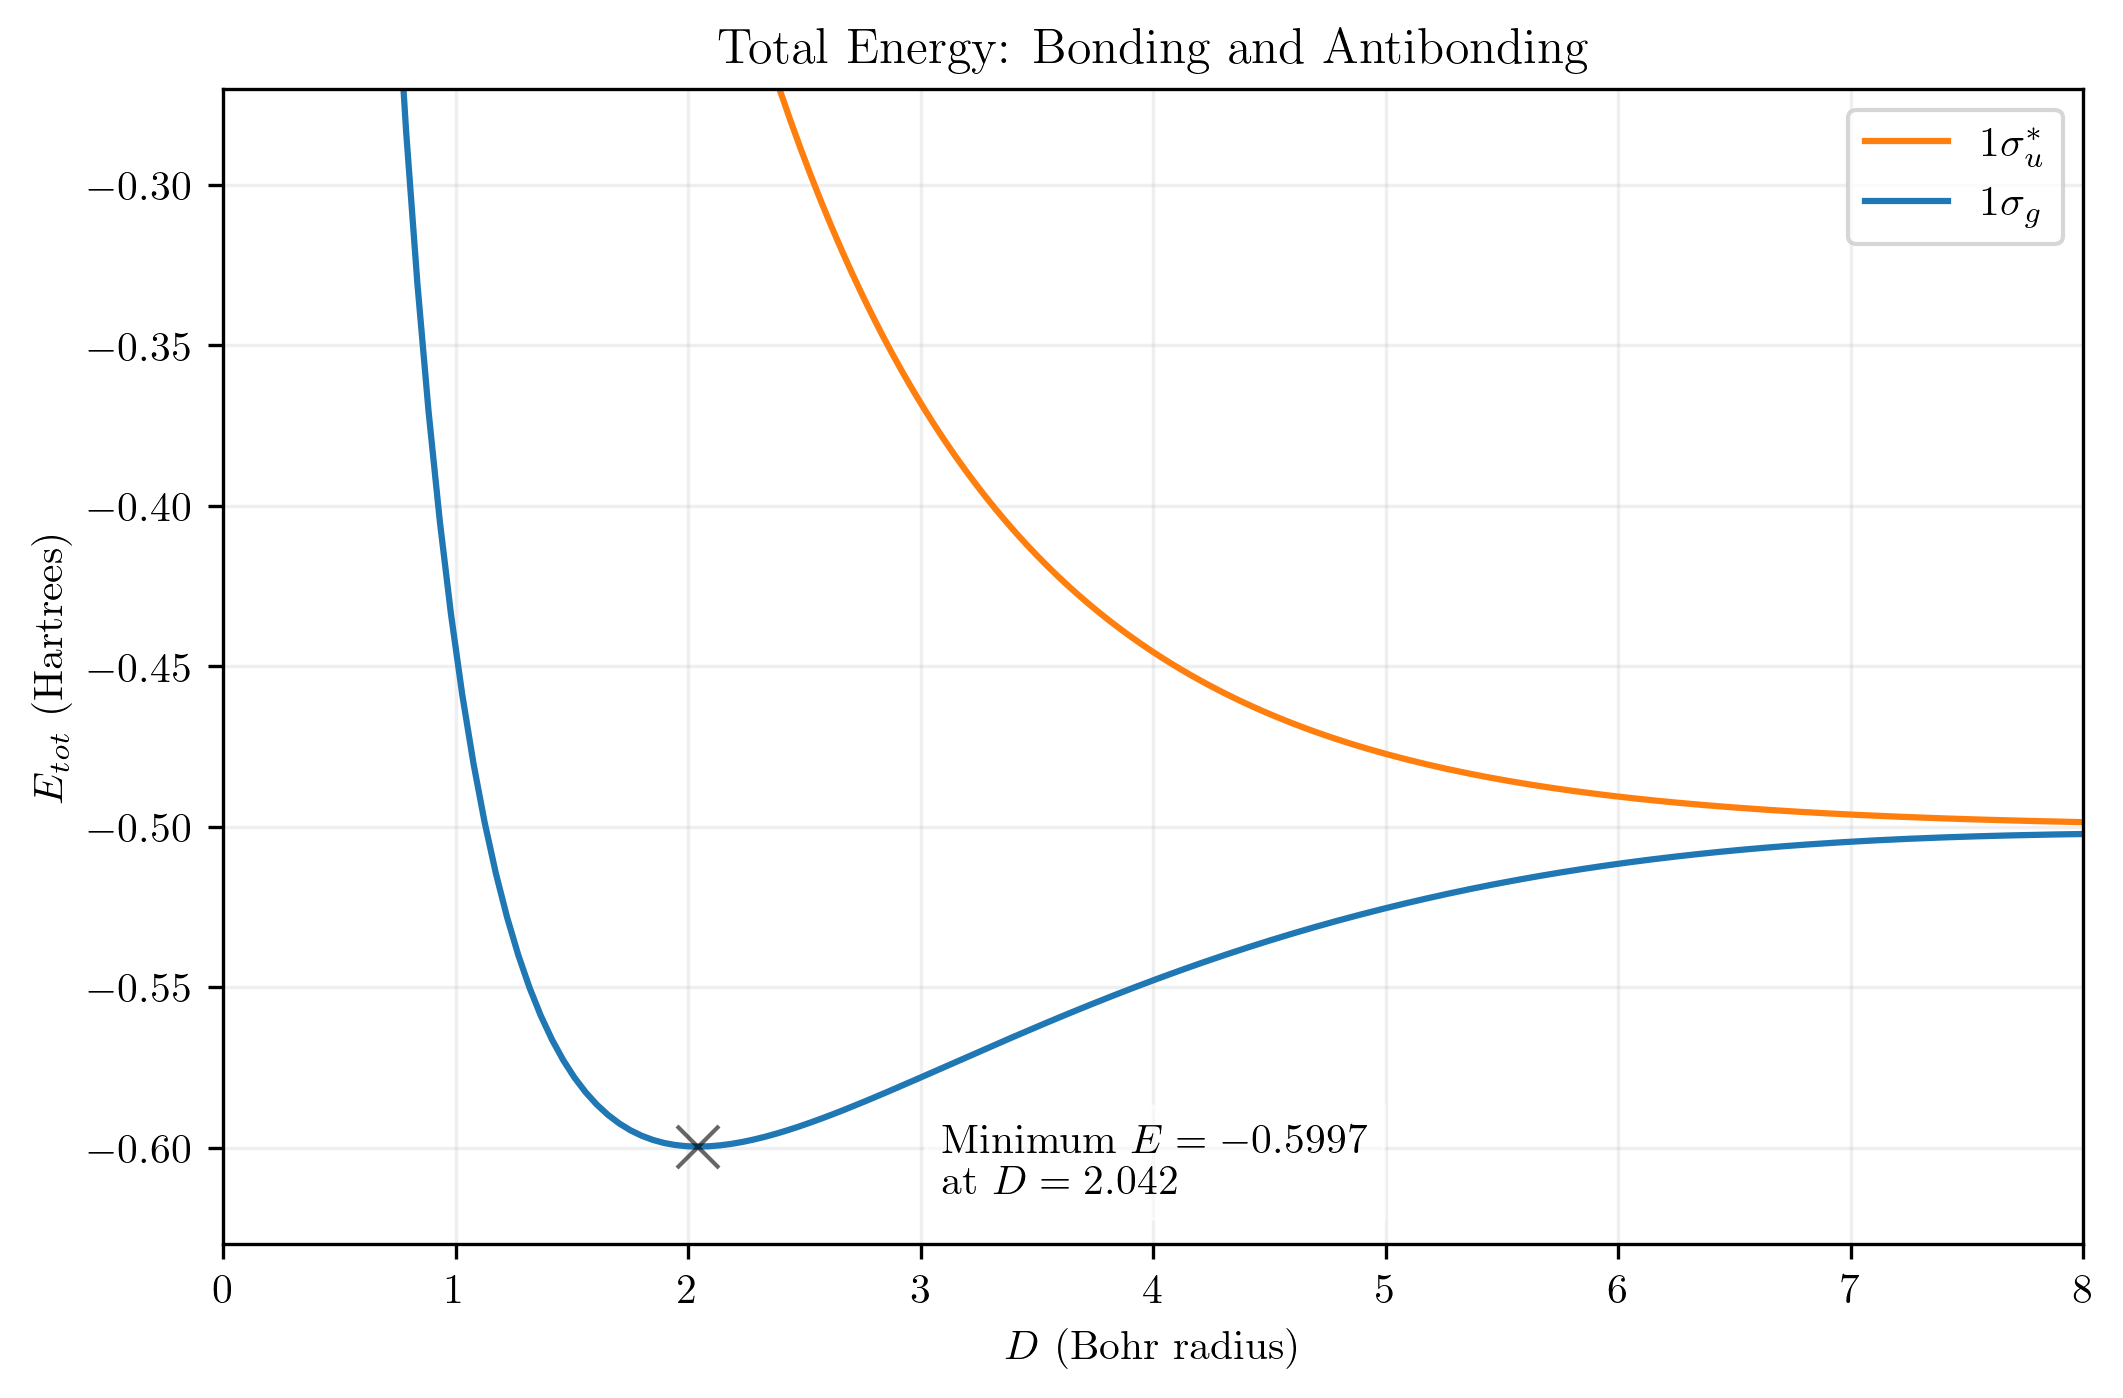

In [7]:
# graph plotting
fig, ax = plt.subplots()

for ind, mo in enumerate(mos):
    
    D_interp = mo_interpolated[mo]['D']
    E_interp = mo_interpolated[mo]['E'] + 1/D_interp
    
    ax.plot(D_interp, E_interp, label=mo_latex[mo])

# plot energy minimum
ax.plot([min_E_D], [min_E], marker='x', 
        markersize=10, color='k', alpha=0.6)
t = ax.text(min_E_D + 1.05, min_E - 0.005, 
            f'Minimum $E = {min_E:.4f}$\n at $D = {min_E_D:.3f}$',
            va='center', ha='left')
t.set_bbox(dict(facecolor='w', edgecolor='w', alpha = 0.5))

# reversed legend order
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), loc=1)

ax.grid(which='both', alpha=0.2)
ax.set_xlim([0, 8])
ax.set_ylim([-0.63, -0.27])
ax.set_xlabel('$D$ (Bohr radius)')
ax.set_ylabel('$E_{tot}$ (Hartrees)')
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))
ax.set_title('Total Energy: Bonding and Antibonding');

The energy minimum is $E_{tot} = -0.5997$ at $D = 2.042$. These values are close to the values reported in literature.

| Source                                    | $E_{tot}$ |  $D_{e}$     |
|-------------------------------------------|-----------|--------------|
| Experimental data                         | 2.00      | -0.602       |
| Numerical calculation by Burrau           | 2.0       | -0.5990      |
| Numerical calculation by Schaad and Hicks | 1.9972    | -0.602634619 |
| This calculation                          | 2.0418    | -0.59971     |



### Comparison with LCAO

We will now compare the results with an easier way of obtaining approximate MOs. 

With linear combinations of atomic orbitals (LCAO), MOs that approximate $1 \sigma_{g}$ and $1 \sigma_{u}^{*}$ (from now on denoted as exact MO) can be constructed from hydrogen $1s$ orbitals.

$$1 \sigma_{g} \approx \sigma_{g1s} = C_{+} \left ( 1s_{A} + 1s_{B} \right )$$

$$1 \sigma_{u}^{*} \approx \sigma_{u1s}^{*} = C_{-} \left ( 1s_{A} - 1s_{B} \right )$$

By calculating various integrals, normalization constants $C_+$ and $C_-$, as well as the energy of $\sigma_{g1s}$ and $\sigma_{u1s}^{*}$ (denoted as $E_+$ and $E_-$) can be obtained. Detailed treatment of deriving and calculating the integrals will not be covered, but the results of such calculations are supplied below.

Overlap integral:

$$S(D) = e^{-D}\left ( 1 + D + \frac{D^2}{3} \right )$$

Coulomb integral:

$$J = e^{-2D}\left ( 1+\frac{1}{D} \right ) $$

Exchange integral:

$$K = \frac{S}{D} - e^{-D}\left ( 1 + D \right )$$

Energy values of $\sigma_{g1s}$ and $\sigma_{u1s}^{*}$:

$$\Delta E_+ = E_+ - E_{1s} = \frac{J + K}{1 + S}$$

$$\Delta E_- = E_- - E_{1s} = \frac{J - K}{1 - S}$$

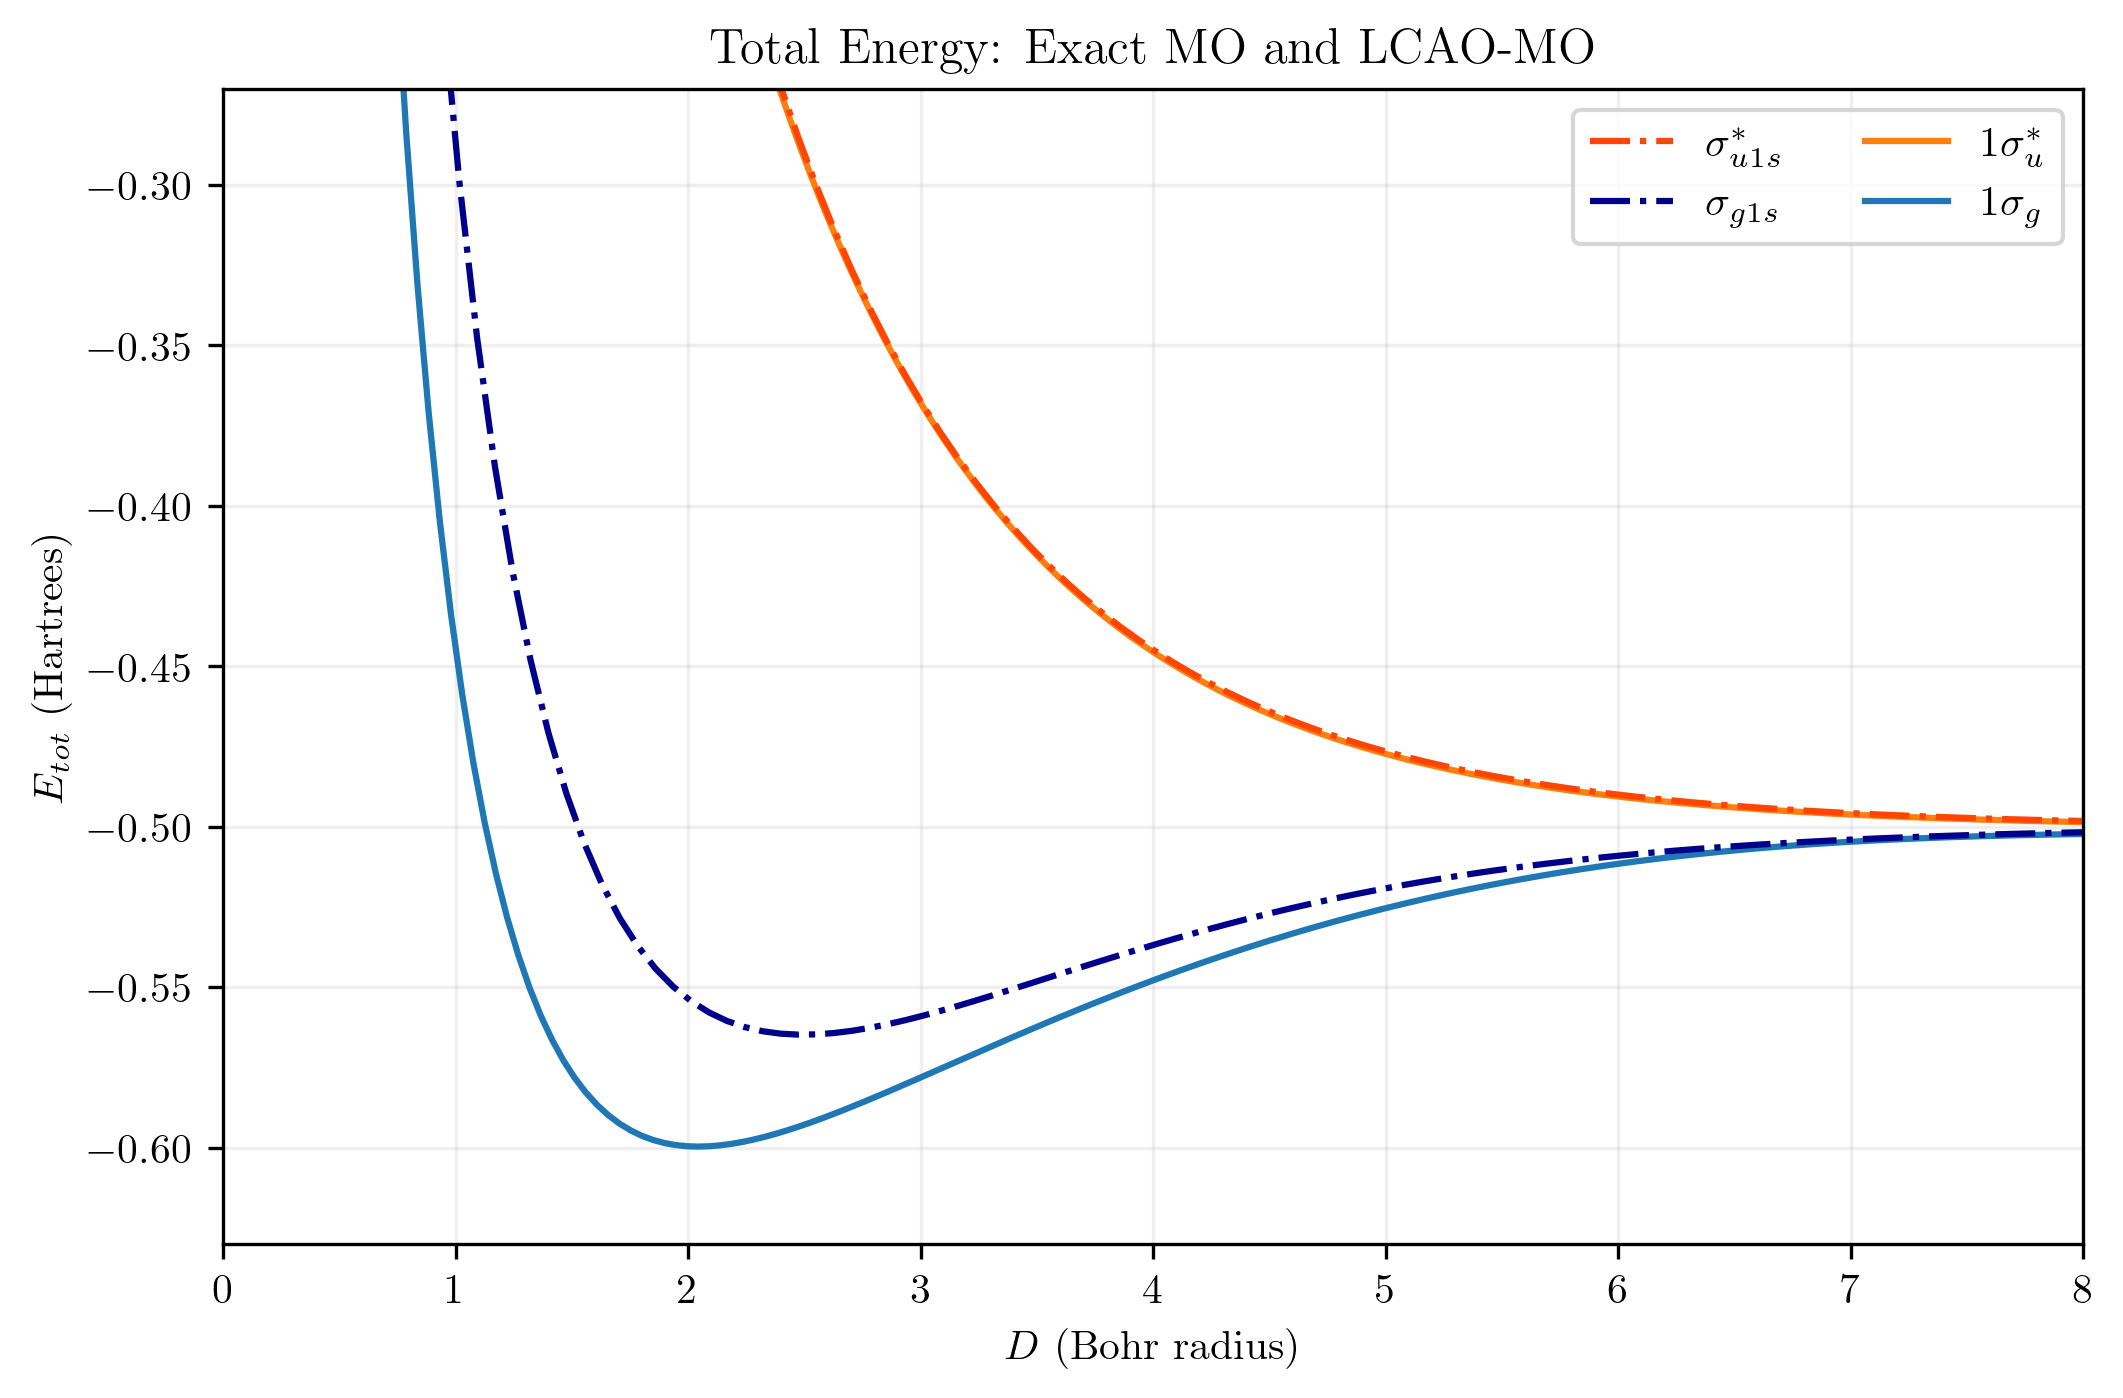

In [8]:
S = lambda D: np.exp(-D) * (1+D+((D**2)/3))
J = lambda D: np.exp(-2*D) * (1+(1/D))
K = lambda D: (S(D)/D) - np.exp(-D) * (1+D)

E_plus = lambda D: (J(D)+K(D))/(1+S(D))
E_minus = lambda D: (J(D)-K(D))/(1-S(D))

LCAO_notation = [r'$\sigma_{g1s}$', r'$\sigma_{u1s}^*$']

# directly from the previous example
fig, ax = plt.subplots()

for ind, mo in enumerate(mos):
    
    D_interp = mo_interpolated[mo]['D']
    E_interp = mo_interpolated[mo]['E'] + 1/D_interp
    
    ax.plot(D_interp, E_interp, label=mo_latex[mo])


# plotting LCAO-MO E values
colors = ['darkblue', 'orangered']

for l in range(2):
    # l == 0: LCAO equivalent of 1 sigma g
    # l == 1: LCAO equivalent of 1 sigma u *
    delta_E = E_plus if l == 0 else E_minus
    LCAO_E = np.vectorize(lambda D: delta_E(D) - 0.5)

    ax.plot(np.linspace(0.4, 8.0, 100), 
            LCAO_E(np.linspace(0.4, 8.0, 100)), 
            ls='-.', color=colors[l], label=LCAO_notation[l])

# reversed legend order
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), loc=1, ncol=2) 
    
ax.grid(which='both', alpha=0.2)
ax.set_xlim([0, 8])
ax.set_ylim([-0.63, -0.27])
ax.set_xlabel('$D$ (Bohr radius)')
ax.set_ylabel('$E_{tot}$ (Hartrees)')
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))
ax.set_title('Total Energy: Exact MO and LCAO-MO');

With LCAO, a result that is qualitatively correct was obtained with little time and effort.